In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, find_peaks

from autophasemap import compute_elastic_kmeans, plot_clusters, compute_BIC

In [3]:
samples = pd.read_csv('./grid/grid.csv')
spectra = pd.read_excel('./grid/Grid.xlsx')
q = spectra['Wavelength'].values.astype('double')
Iq = spectra.iloc[:,1:].values.astype('double').T
Iq = Iq[:-1,:]
N = Iq.shape[0]
n_domain = len(q)
print('Function domain: ', q.shape)
print('Sampled functions : ', Iq.shape)

Function domain:  (101,)
Sampled functions :  (48, 101)


In [4]:
comps = samples.values
AG_x = comps[:,0]*0.00064/350*10**5
AA_x = comps[:,1]*0.00630/350*10**4
C = np.hstack((AG_x.reshape(-1,1)-0.1, AA_x.reshape(-1,1)-0.1))
print('Composition space : ', C.shape)

Composition space :  (48, 2)


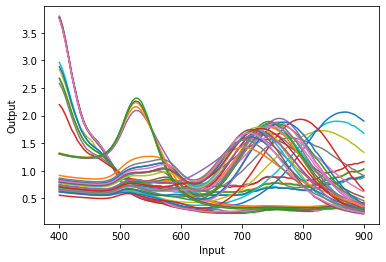

In [5]:
class DataSet:
    def __init__(self, C, q, Iq, N, n_domain=200):
        self.n_domain = n_domain
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = N
        self.Iq = Iq
        self.C = C
        self.q = q
        
    def generate(self, process=None):
        if process=="normalize":
            self.F = [self.Iq[i]/self.l2norm(self.Iq[i]) for i in range(self.N)]
        elif process is None:
            self.F = [self.Iq[i] for i in range(self.N)]
            
        return
        
    def l2norm(self, f):
        norm = np.sqrt(np.trapz(f**2, data.t))
        
        return norm
    
    def _smoothen(self, f):
        f_hat = savgol_filter(f, 8, 3)
        
        return f_hat

data = DataSet(C, q, Iq, N, n_domain=n_domain)
data.generate(process="normalize")

fig, ax = plt.subplots()
for i in range(data.N):
    ax.plot(data.q, data.F[i])
ax.set_xlabel('Input')
ax.set_ylabel('Output')
plt.show()

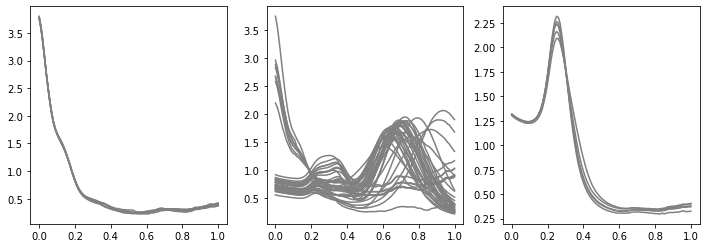

In [6]:
# get features
def featurize(x,y):
    "Use peak locations to determine morphology"
    peaks, properties = find_peaks(y, prominence=0.05, width=0.4)
    if len(peaks)==0:
        shape = 0
    elif (x[peaks]>600).any():
        shape = 1
    elif not (x[peaks]>600).any():
        shape = 2
        
    return shape

fig, axs = plt.subplots(1, 3, figsize=(4*3, 4))
for i in range(data.N):
    s = featurize(data.q, data.F[i])
    axs[s].plot(data.t, data.F[i], color='grey')
plt.show()

In [11]:
N_CLUSTERS = 3
MAX_ITER = 100
VERBOSE = 3

out = compute_elastic_kmeans(data, N_CLUSTERS, 
    max_iter=MAX_ITER, 
    verbose=VERBOSE, 
    smoothen=True
    )
BIC = compute_BIC(data, out.fik_gam, out.qik_gam, out.delta_n)
print('BIC with %d clusters is :%.2f'%(N_CLUSTERS, BIC))

(0:00:00.464239)	Iteration : 0	Error : 0.4374
(0:00:05.144956)	Iteration : 10	Error : 0.0598
(0:00:09.664953)	Iteration : 20	Error : 0.0582
(0:00:14.163497)	Iteration : 30	Error : 0.0825
(0:00:18.612949)	Iteration : 40	Error : 0.0362
(0:00:23.563787)	Iteration : 50	Error : 0.0922
(0:00:28.044504)	Iteration : 60	Error : 0.0961
(0:00:32.562954)	Iteration : 70	Error : 0.0660
(0:00:37.079903)	Iteration : 80	Error : 0.0997
(0:00:41.634369)	Iteration : 90	Error : 0.0910
Total iterations 99	Error : 0.0389 and took 0:00:45.805205
BIC with 3 clusters is :1366.40


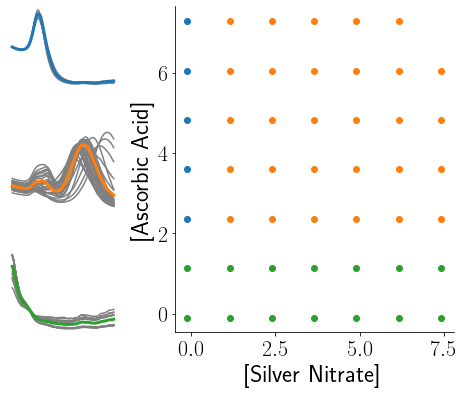

In [12]:
pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight'
              } 
from matplotlib.cm import get_cmap
cmap = get_cmap('tab10')

with plt.style.context(pyplot_style):
    layout = [['A1','B', 'B'], 
                ['A2', 'B', 'B'],
                ['A3', 'B', 'B']
                ]
    fig, axs = plt.subplot_mosaic(layout, figsize=(4*2, 4*1.5))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    ax_curves = [axs["A1"], axs["A2"], axs["A3"]]
    for k in range(N_CLUSTERS):
        Mk = np.argwhere(out.delta_n==k).squeeze()
        ax = ax_curves[k]
        for i in Mk:
            ax.plot(data.t, data.F[i], color='grey')

        ax.plot(data.t, out.templates[k], lw=3.0, color=cmap(k)) 
        ax.axis('off')

        axs["B"].scatter(data.C[Mk,0], data.C[Mk,1], color=cmap(k))
    axs["B"].set_xlabel(r'[Silver Nitrate]', fontsize = 24)
    axs["B"].set_ylabel(r'[Ascorbic Acid]', fontsize = 24)
    plt.savefig("goldnano_autophasemap.png")    
    plt.show()